# **WQU Capstone Project**

### **Dynamic MACD Trading with Multi-modal Agent**

#### **Student Group 6386**
##### Sunil Sharma ([sunilksh+mscfe@outlook.com](mailto:sunilksh+mscfe@outlook.com))

---

### Objective

This notebook aims to test backtesting capability with backtrader for Moving Average Convergence Divergence (MACD) trading strategy on historical stock data for a stock (YESBANK in this case). By doing this, we can evaluate the strategy's performance and determine its viability for trading, which will later integrated with AI Agent.

### Summary

- **Define the Strategy**: Implements a MACD-based strategy that buys when the MACD line crosses above the signal line and sells when it crosses below.
- **Backtesting**: Applies the strategy to YESBANK historical data from 2020-01-01 to 2023-12-31 using Backtrader.
- **Performance Metrics**: Analyzes key metrics like final portfolio value, Sharpe ratio, drawdown, returns, and trade statistics.
- **Visualization**: Saves a plot of the backtest results to visually assess the strategy's performance.

In [37]:
import backtrader as bt
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

In [42]:
# Define the stock symbol
stock_symbol = 'YESBANK'  

### Setting Up the Strategy
Here we define our trading approach. MACD strategy will buy shares when a positive crossover happens and sell when a negative crossover occurs.


In [ ]:
class MACDStrategy(bt.Strategy):
    params = (('fast_period', 12), ('slow_period', 26), ('signal_period', 9),)

    def __init__(self):
        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.params.fast_period,
            period_me2=self.params.slow_period,
            period_signal=self.params.signal_period
        )
        self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

    def next(self):
        if self.crossover > 0:
            self.buy()
        elif self.crossover < 0:
            self.sell()

### Getting the Data Ready
Next, we'll load the stock data from a CSV file and prepare it for analysis, with backtesting tool.

In [49]:

class BackTraderUtils:

    def back_test_macd(
        self,
        csv_file_path: str,
        start_date: str,
        end_date: str,
        strategy_params: str = "",
        cash: float = 10000.0,
        save_fig: str | None = None,
    ) -> str:
        """
        Use the Backtrader library to backtest the MACD strategy on historical stock data from a CSV file.
        """
        cerebro = bt.Cerebro()

        strategy_class = MACDStrategy
        strategy_params = json.loads(strategy_params) if strategy_params else {}
        cerebro.addstrategy(strategy_class, **strategy_params)

        # Read data from CSV file
        df = pd.read_csv(csv_file_path, parse_dates=['date'])
        df['datetime'] = pd.to_datetime(df['date'])
        df.set_index('datetime', inplace=True)
        df = df[['open', 'high', 'low', 'close', 'volume']]

        # Filter the data based on the start and end date
        df = df[start_date:end_date]
        
        if df.empty:
            raise ValueError("No data available for the specified date range.")
        # Rename columns to match Backtrader expectations
        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

        # Create a data feed
        data = bt.feeds.PandasData(dataname=df)
        cerebro.adddata(data)  # Add the data feed
        
        # Set our desired cash start
        cerebro.broker.setcash(cash)

        # Attach analyzers
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe_ratio")
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name="draw_down")
        cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trade_analyzer")

        stats_dict = {"Starting Portfolio Value": cerebro.broker.getvalue()}

        results = cerebro.run()  
        first_strategy = results[0]

        # Access analysis results
        stats_dict["Final Portfolio Value"] = cerebro.broker.getvalue()
        stats_dict["Sharpe Ratio"] = (
            first_strategy.analyzers.sharpe_ratio.get_analysis()
        )
        stats_dict["Drawdown"] = first_strategy.analyzers.draw_down.get_analysis()
        stats_dict["Returns"] = first_strategy.analyzers.returns.get_analysis()
        stats_dict["Trade Analysis"] = (
            first_strategy.analyzers.trade_analyzer.get_analysis()
        )

        if save_fig:
            directory = os.path.dirname(save_fig)
            if directory:
                os.makedirs(directory, exist_ok=True)
            plt.figure(figsize=(12, 8))
            cerebro.plot()
            plt.savefig(save_fig)
            plt.close()

        return "Back Test Finished. Results: \n" + json.dumps(stats_dict, indent=2)

In [52]:
def process_results(result_str: str) -> dict:
    # Extract the JSON part of the result_str
    json_str = result_str.split("Results: \n")[1]
    stats_dict = json.loads(json_str)
    
    final_portfolio_value = round(stats_dict["Final Portfolio Value"], 2)
    sharpe_ratio = stats_dict["Sharpe Ratio"]["sharperatio"]
    sharpe_ratio = round(sharpe_ratio, 2) if sharpe_ratio is not None else "N/A"
    drawdown = round(stats_dict["Drawdown"]["drawdown"], 2)
    max_drawdown = round(stats_dict["Drawdown"]["max"]["drawdown"], 2)
    total_return = round(stats_dict["Returns"]["rtot"] * 100, 2)  
    annualized_return = round(stats_dict["Returns"]["rnorm100"], 2)
    total_trades = stats_dict["Trade Analysis"]["total"]["total"]
    winning_trades = stats_dict["Trade Analysis"]["won"]["total"]
    losing_trades = stats_dict["Trade Analysis"]["lost"]["total"]
    gross_profit = round(stats_dict["Trade Analysis"]["won"]["pnl"]["total"], 2)
    gross_loss = round(abs(stats_dict["Trade Analysis"]["lost"]["pnl"]["total"]), 2)
    net_profit_loss = round(gross_profit - gross_loss, 2)

    # Print the formatted results with explicit units
    summary = {
        "Final Portfolio Value (Currency)": f"{final_portfolio_value}",
        "Sharpe Ratio": sharpe_ratio,
        "Drawdown (%)": f"{drawdown}%",
        "Max Drawdown (%)": f"{max_drawdown}%",
        "Total Return (%)": f"{total_return}%",  
        "Annualized Return (%)": f"{annualized_return}%",
        "Total Trades (Count)": total_trades,
        "Winning Trades (Count)": winning_trades,
        "Losing Trades (Count)": losing_trades,
        "Gross Profit (Currency)": f"{gross_profit}",
        "Gross Loss (Currency)": f"{gross_loss}",
        "Net Profit/Loss (Currency)": f"{net_profit_loss}"
    }

    return summary

### Running the Backtest
We'll run our MACD strategy on the historical data. This step simulate the trading over time, starting with some amount of cash and also tracking performance.
After the backtest, we'll dive into the results. We'll look at key metrics like the final amount of money we end up with, the risk that was taken, and how often our trades were successful.


In [59]:
utils = BackTraderUtils()
raw_result_str = utils.back_test_macd(
    csv_file_path=f'..\..\data\DailyData\{stock_symbol}.csv',
    start_date='2020-01-01',
    end_date='2023-12-31',
    strategy_params='{"fast_period": 12, "slow_period": 26, "signal_period": 9}',
    cash=10000.0,
    save_fig="macd_backtest.png"
)

print(raw_result_str)  

processed_results = process_results(raw_result_str) 
for key, value in processed_results.items():
    print(f"{key}: {value}")  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Back Test Finished. Results: 
{
  "Starting Portfolio Value": 10000.0,
  "Final Portfolio Value": 9981.149999999998,
  "Sharpe Ratio": {
    "sharperatio": -18.413135606952324
  },
  "Drawdown": {
    "len": 947,
    "drawdown": 0.2199307218226622,
    "moneydown": 22.000000000003638,
    "max": {
      "len": 947,
      "drawdown": 0.28291088307182505,
      "moneydown": 28.299999999999272
    }
  },
  "Returns": {
    "rtot": -0.0018867788482710755,
    "ravg": -1.900079404099774e-06,
    "rnorm": -0.00047870539382644385,
    "rnorm100": -0.047870539382644385
  },
  "Trade Analysis": {
    "total": {
      "total": 39,
      "open": 1,
      "closed": 38
    },
    "streak": {
      "won": {
        "current": 0,
        "longest": 2
      },
      "lost": {
        "current": 2,
        "longest": 3
      }
    },
    "pnl": {
      "gross": {
        "total": -18.64999999999999,
        "average": -0.4907894736842103
      },
      "net": {
        "total": -18.64999999999999,
    

### Visualizing the Backtest Results
Displaying the image of our backtest results to assess how our MACD strategy performed over the specified period.

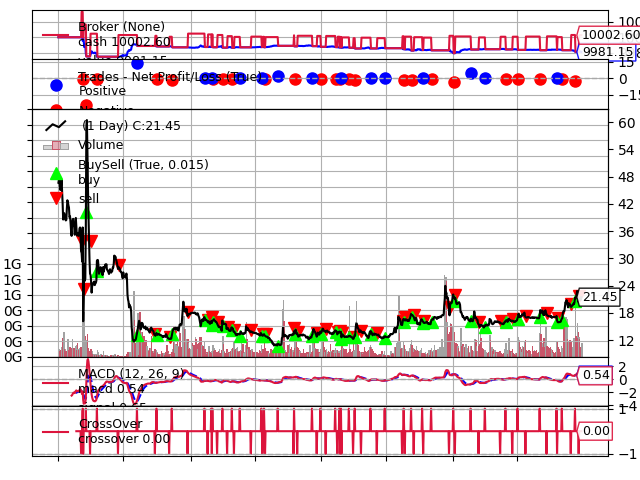

In [61]:
from IPython.display import Image, display

# Display the backtest image
display(Image(filename="macd_backtest.png"))